# Design Document: Movie Genre Classification

## Overview
The purpose of this notebook is a walkthrough from data cleaning & preprocessing to model selection, hyper-parameter tuning and evaluation.

A more production ready implementation (using scikit-learn Pipeline) can be found in:
 - `prepare_movie_genre_dataset.py` and `prepare_simplified_movie_genre_dataset.py` for data preprocessing, 
 - `train_movie_genre_classifier.py` for training
 - `movie_genre_classifier_predict.py` & `movie_genre_classifier_server.py` for inference.

---

## Data Cleaning and Preprocessing
1. **Defining two preprocessing data pipelines**
   - As part of this execise (even though it wasn't part of the requirements) I defined two data preprocessing pipelines:
     - `prepare_movie_genre_dataset.py`: Preprocesses the original dataset with all features including: languages, countries, title, plot summary, feature_length
     ```
     data_pipe = Pipeline(steps=[
        ('parse_json', ParseJsonColumns(columns=['languages', 'genres', 'countries'])),
        ('convert_langcodes', ConvertToLangCodes()),
        ('clean_countries', CleanCountryNames()),
        ('fill_numerical', FillMissingValues(['feature_length'], fill_func='median')),
        ('text_embeddings', TextEmbeddings(['title', 'plot_summary'])),
        ('multilabel_X', EncodeMultiLabel(['langcodes', 'countries_parsed'], mca_components_ratio=.8)),
        ('multilabel_y', EncodeMultiLabel(['genres_parsed'])),
        ('balance_y', MultilabelUnderSampler(cols_prefix='genres_parsed_')),
        ('np', Numpyfier()),
        ('scaler', StandardScaler()),
    ])
     ```
     - `prepare_simplified_movie_genre_dataset.py`: Preprocesses a simplified dataset with only the plot summary as input (this pipeline is a subset of the first one)
     ```
     data_pipe = Pipeline(steps=[
        ('parse_json', ParseJsonColumns(columns=['genres'])),
        ('text_embeddings', TextEmbeddings(['plot_summary'])),
        ('multilabel_y', EncodeMultiLabel(['genres_parsed'], mca_components_ratio=None)),  # encode y with one-hot without MCA
        ('balance_y', MultilabelUnderSampler(cols_prefix='genres_parsed_')),
        ('np', Numpyfier()),
        ('scaler', StandardScaler()),
    ])
     ```


2. **Handling Missing Values:**
   - Any rows with missing in y (movie genre), are removed from the dataset
   - release_date is removed due to irrelevant to predicting y, feature_length is removed due to high missing values percentage

3. **Text Preprocessing:**
   - Titles and plot summaries are converted text embeddings in order to convert what otherwise would be unstable unstructured data into fixed length vectors that capture the semantic meaning of the text.
   - huggingface embeddings model used: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
   - multi-lingual text embeddings haven't been explored as part of this exercise, but could be a necessity if non-english text is to be supported

4. **Multi-Label Features Preprocessing:**
   - multi-label features are represented as json strings, which are parsed, and values are extracted from dict values of the json strings
   - handling redundant/incorrect values in languages & countries: languages are converted from natural language to language codes using langcodes module (these some failures to identify some of the languages with this solution), some values in countries contain language values, which is handles to some extent.
   - one-hot encoding is used using MultiLabelBinarizer, and MCA (Multiple Correspondence Analysis) is used to reduce the dimensionality of the one-hot encoded features (except genre, since predicted genre values must remain interpretable). I explored multiple n_components values to find one that gives at least 90% of explained variance ratio.

5. **Missing values**
    - missing values are handled depending on the feature type:
    - multi-label values are filled with empty lists before encoded
    - numerical values are filled with median values

6. **Balancing Multi-Label Classes:**
    - in order to address potential class imbalances for genre, I used LabelPowerset to convert y to 1-D followed by RandomUnderSampler.

---

## Model Choices and Hyper-parameter Search

1. **Model Selection:**
   - **Baseline Models:** I compared training cross-validation results of models like KNN, DecisionTree, Logistic Regression, SGD, LinearSVC, mutiple variations of XGBoost for handling multi-label data. Note that these models were wrapped with OneVsRestClassifier or MultiOutputClassifier to handle multi-label classification.
   - **XGBoost Classifier:** Even though XGBoost wasn't at the top of the results (with it's default hyper-parameters), I chose it for its efficiency and performance in handling structured data and capability of capturing complex patterns, GPU training support, and room for improvement given more hyper-parameter tuning.


2. **Hyper-parameter Search:**
   - **Initial Parameter Search:**
     - Parameters such as `n_estimators` (number of trees) and `learning_rate` are chosen based on preliminary runs.
     - A broad grid search is conducted to narrow down promising parameter ranges.
   - **Refinement Search:**
     - A more focused grid search around the best initial parameters is conducted.
     - Parameters tuned include: n_estimators, max_depth, min_child_weight.
     - Note that due to time constraints, and the time-intensive nature of hyper-parameter tuning, It should be possible to achieve much better results with more time and resources.

3. **Model Training:**
   - The best model is trained on the entire training dataset using the optimal hyper-parameters identified.
   - **Standardization:** Features are standardized to have zero mean and unit variance, which is particularly important for gradient-based models like XGBoost.

4. **Model Evaluation:**
   - Across my training sessions, I chose to use `recall_macro` because it teats each class equally, providing a balanced measure that can reveal poor performance on minority classes.

---

### Setup Environment ###
```
conda env create -f environment.yml
conda activate movie_genre_demo
```

### plot summary dataset preprocessing + training + prediction example: ###
```
python prepare_simplified_movie_genre_dataset.py data/movie_data.json movie_data_simple_test.npz --pipeline_path models/preprocessing_pipeline_simple.pkl;
python train_movie_genre_classifier.py movie_data_simple_test.npz models/movie_genre_classifier_simple.pkl <any optional hyper-parameter arguments>;
python movie_genre_classifier_predict.py models/preprocessing_pipeline_simple.pkl models/movie_genre_classifier_simple.pkl --input_path example_inputs/plot_summary_1.json
```

Or alternatively, you can launch the server and run tests on it:
```
python movie_genre_classifier_server.py models/preprocessing_pipeline_simple.pkl models/movie_genre_classifier_simple.pkl
python server_test.py example_inputs/plot_summary_1.json
```
Pretrain model is included in `models` directory, and example input in `example_inputs`


In [1]:
# install dependencies
#!conda install -c conda-forge scikit-learn lightgbm langcodes prince xgboost imblearn scikit-multilearn transformers pytorch -y

In [1]:
# import dependencies
import itertools
import json
import os
import time
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from skmultilearn.problem_transform import LabelPowerset
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, HalvingGridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import langcodes
from prince import MCA
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import torch
from xgboost import XGBClassifier, DMatrix

# set manual seed for reproducibility
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
data_json_path = 'data/movie_data.json'
data_csv_path = 'data/movie_data.csv'
if not os.path.exists(data_csv_path):
    with open(data_json_path, 'r') as f:
        data = list(map(json.loads, f.readlines()))
        df = pd.DataFrame(data)
        df.to_csv(data_csv_path, index=False)
else:
    df = pd.read_csv(data_csv_path)

Data Exploratoin

In [4]:
# print columns types, shape, missing values ratio, value counts
print(df.info())
print(f'{df.shape=}')
missing_values_ratio = (df.isnull().sum() / df.shape[0]).sort_values(ascending=False)
print(f'missing values ratio: {print(missing_values_ratio)}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   languages                 29922 non-null  object 
 1   genres                    29922 non-null  object 
 2   title                     29922 non-null  object 
 3   release_date              28061 non-null  object 
 4   countries                 29922 non-null  object 
 5   movie_box_office_revenue  5379 non-null   float64
 6   plot_summary              30000 non-null  object 
 7   feature_length            25255 non-null  float64
dtypes: float64(2), object(6)
memory usage: 1.8+ MB
None
df.shape=(30000, 8)
movie_box_office_revenue    0.820700
feature_length              0.158167
release_date                0.064633
languages                   0.002600
genres                      0.002600
title                       0.002600
countries                   0.002600
plot_s

In [5]:
# check for rows that have missing values across all features
print(df.isnull().all(axis=0).sum())

0


In [6]:
print(df.head())

                                           languages  \
0                     {'/m/07c9s': 'Tamil Language'}   
1                 {'/m/02h40lc': 'English Language'}   
2                     {'/m/03k50': 'Hindi Language'}   
3  {'/m/07qv_': 'Tagalog language', '/m/01jb8r': ...   
4                 {'/m/02h40lc': 'English Language'}   

                                              genres               title  \
0                            {'/m/07s9rl0': 'Drama'}  Periya Idathu Penn   
1  {'/m/01jfsb': 'Thriller', '/m/02n4kr': 'Myster...           The Flock   
2    {'/m/02kdv5l': 'Action', '/m/07s9rl0': 'Drama'}                Gang   
3  {'/m/0hn10': 'LGBT', '/m/07s9rl0': 'Drama', '/...            Daybreak   
4  {'/m/06cvj': 'Romantic comedy', '/m/02l7c8': '...              Tomboy   

  release_date                                  countries  \
0         1963                      {'/m/03rk0': 'India'}   
1         2007  {'/m/09c7w0': 'United States of America'}   
2   2000-04-14         

In [7]:
# remove irrelevant attributes
# release date doesn't seem to add any useful information for predicting genres
df.drop('release_date', axis=1, inplace=True)

In [8]:
### There aren't any rows with missing values across all features

In [9]:
print('unique values:')
str_cols = df.select_dtypes(include='object').columns
for col in str_cols:
    # print number of unique values
    print(f'{col}: {df[col].nunique()}')

unique values:
languages: 1148
genres: 13274
title: 28703
countries: 1197
plot_summary: 29992


In [10]:
n_rows = df.shape[0]
df.dropna(subset=['genres'], how='any', inplace=True)
print(f'dropped {n_rows - df.shape[0]} rows')

dropped 78 rows


Multilabel Encoding

In [11]:
# parse json columns & extract categorical attributes
# even though the keys aren't human readable, the values are
# we'll convert the dicts to lists of values

def parse_json_col(str_):
    return list(eval(str_).values())

json_cols = ['languages', 'genres', 'countries']
# df_raw[json_cols].fillna('{}', inplace=True)
for col in json_cols:
    # treat missing values as empty dict
    df[col] = df[col].fillna('{}')
    df[f'{col}_parsed'] = df[col].astype(str).apply(parse_json_col)
    # drop col
    df.drop(col, axis=1, inplace=True)

parsed_json_cols = [f'{col}_parsed' for col in json_cols]
print(df[parsed_json_cols].head())

                                    languages_parsed  \
0                                   [Tamil Language]   
1                                 [English Language]   
2                                   [Hindi Language]   
3  [Tagalog language, Filipino language, English ...   
4                                 [English Language]   

                                       genres_parsed  \
0                                            [Drama]   
1  [Thriller, Mystery, Crime Fiction, Drama, Crim...   
2                                    [Action, Drama]   
3       [LGBT, Drama, Filipino Movies, World cinema]   
4     [Romantic comedy, Romance Film, Indie, Comedy]   

             countries_parsed  
0                     [India]  
1  [United States of America]  
2                     [India]  
3               [Philippines]  
4  [United States of America]  


In [12]:
# drop all rows where y is empty list
n_rows = df.shape[0]
df = df[df.genres_parsed.apply(len) > 0]
print(f'dropped {n_rows - df.shape[0]} rows')

dropped 279 rows


In [13]:
# print unique values in each of the parsed json columns
for col in parsed_json_cols:
    print('-' * 100)
    print(f'{col}:')
    print(sorted(set(itertools.chain.from_iterable(df[col].values))))

----------------------------------------------------------------------------------------------------
languages_parsed:
['Aboriginal Malay languages', 'Afrikaans Language', 'Akan Language', 'Albanian language', 'Algonquin Language', 'American English', 'American Sign Language', 'Amharic Language', 'Apache, Western Language', 'Arabic Language', 'Aramaic language', 'Armenian Language', 'Assamese Language', 'Assyrian Neo-Aramaic Language', 'Assyrian language', 'Australian Aboriginal Pidgin English', 'Australian English', 'Awadhi Language', 'Azerbaijani language', 'Bambara language', 'Belarusian language', 'Bengali Language', 'Bhojpuri Language', 'Bosnian language', 'Brazilian Portuguese', 'Bulgarian Language', 'Burmese Language', 'Cantonese', 'Catalan language', 'Cebuano language', 'Chadian Arabic', 'Chechen Language', 'Chewa language', 'Cheyenne Language', 'Chhattisgarhi Language', 'Chinese language', 'Chinese, Hakka Language', 'Chinese, Jinyu Language', 'Classical Arabic', 'Corsican Lang

Some values in languages_parsed need to be merged like "German" and "German Language"

We'll use langcodes to convert natural language names to language codes

Note: this isn't a perfect solution, langcodes fails to identify some of the languages included in the dataset,  we'll handle them as missing data

In [14]:

# convert to language codes
languages_unique_values = set(itertools.chain.from_iterable(df.languages_parsed.values))
langcode_map = {}
for v in languages_unique_values:
    try:
        langcode_map[v] = langcodes.find(v)
    except LookupError:
        langcode_map[v] = ''

df['langcodes'] = df['languages_parsed'].apply(
    lambda x: [(langcode_map[v].language if isinstance(langcode_map[v], langcodes.Language) else langcode_map[v]) for v in x])
# drop languages_parsed
df.drop('languages_parsed', axis=1, inplace=True)

In [15]:
# Some values in countries column include languages
# remove" Language" from countries_parsed values
df['countries_parsed'] = df['countries_parsed'].apply(lambda x: [v.replace(' Language', '') for v in x])

In [16]:
cat_multi_cols_X = ['langcodes', 'countries_parsed']
cat_multi_cols_y = ['genres_parsed']
cat_multi_cols = cat_multi_cols_X + cat_multi_cols_y
for col in cat_multi_cols:
    print(f'{col} unique values: {len(set(itertools.chain.from_iterable(df[col].values)))}')

langcodes unique values: 155
countries_parsed unique values: 143
genres_parsed unique values: 356


Using one hot encoding will add additional 296 attributes to the dataset, we can use MCA to encode these attributes at a lower dimensionality
We'll start with one hot encoding and use MCA to reduce the dimensionality

In [17]:

df_bak = df.copy()
# df = df_bak.copy()
n_features = df.shape[1]
one_hot_cols_X = []
for col in cat_multi_cols:
    mlb = MultiLabelBinarizer()
    encoded_col = mlb.fit_transform(df[col])
    encoded_df = pd.DataFrame(encoded_col, columns=[f'{col}_{v}' for v in mlb.classes_], index=df.index)
    if col in cat_multi_cols_X:
        one_hot_cols_X.extend(encoded_df.columns)
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(col, axis=1, inplace=True)

print(f'{df.shape=}, {df.shape[1] - n_features} new features added')

df.shape=(29643, 658), 651 new features added


fitting MCA: 100%|██████████| 4/4 [00:44<00:00, 11.01s/it]


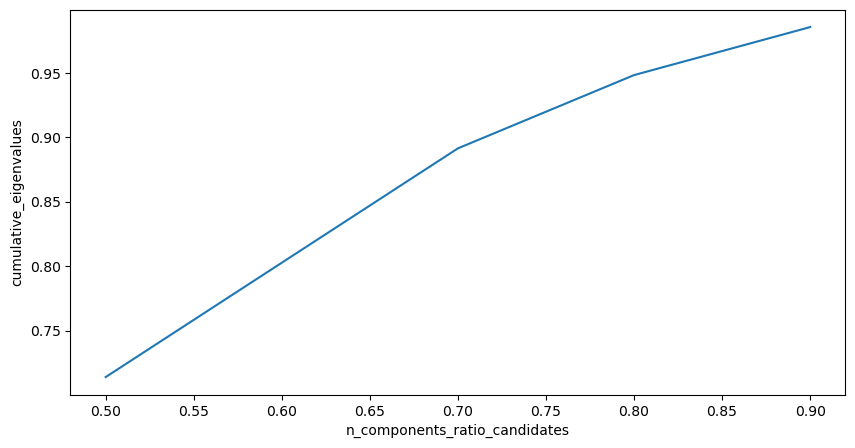

In [18]:
# find best number of components for MCA
n_components_ratio_candidates = (.5, .7, .8, .9)
n_components_candidates = [int(len(one_hot_cols_X)*ratio) for ratio in n_components_ratio_candidates]
cumulative_eigenvalues = []
for n_components in tqdm(n_components_candidates, desc='fitting MCA'):
    mca = MCA(n_components=n_components)
    mca.fit(df[one_hot_cols_X])
    cumulative_eigenvalues.append(mca.eigenvalues_.sum())
# plot cumulative eigenvalues
plt.figure(figsize=(10, 5))
plt.plot(n_components_ratio_candidates, cumulative_eigenvalues)
plt.xlabel('n_components_ratio_candidates')
plt.ylabel('cumulative_eigenvalues')
plt.show()

In [19]:
# int(len(one_hot_cols)*.8) gives .95 of the explained variance
n_components = int(len(one_hot_cols_X)*.8)
mca = MCA(n_components=n_components)
mca_df = mca.fit_transform(df[one_hot_cols_X])
mca_df.columns = [f'mca_{i}' for i in range(n_components)]
# replace one hot encoded columns with MCA columns
df = pd.concat([df, mca_df], axis=1)
df.drop(one_hot_cols_X, axis=1, inplace=True)

In [20]:
# handle numerical columns
numerical_cols = df.select_dtypes(include='number').columns
print((df[numerical_cols].isnull().sum() / df[numerical_cols].shape[0]))
print(df[numerical_cols].describe())

movie_box_office_revenue      0.818642
feature_length                0.151537
genres_parsed_Absurdism       0.000000
genres_parsed_Acid western    0.000000
genres_parsed_Action          0.000000
                                ...   
mca_233                       0.000000
mca_234                       0.000000
mca_235                       0.000000
mca_236                       0.000000
mca_237                       0.000000
Length: 596, dtype: float64
       movie_box_office_revenue  feature_length  genres_parsed_Absurdism  \
count              5.376000e+03    2.515100e+04             29643.000000   
mean               4.937611e+07    1.407794e+02                 0.001720   
std                1.042170e+08    6.804953e+03                 0.041444   
min                1.020000e+04    3.000000e-01                 0.000000   
25%                2.490008e+06    8.600000e+01                 0.000000   
50%                1.231686e+07    9.600000e+01                 0.000000   
75%        

In [21]:
### 82% of rows are missing movie_box_office_revenue, we'll drop this column
df.drop('movie_box_office_revenue', axis=1, inplace=True)
# fill feature_length missing values with the median value
df['feature_length'].fillna(df['feature_length'].median(), inplace=True)

C:\Users\Roman\AppData\Local\Temp\ipykernel_44452\258937842.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['feature_length'].fillna(df['feature_length'].median(), inplace=True)


title and plot_summary attributes are unique per row, therefore it makes more sense to treat them as text features to give them semantic meaning, rather than one-hot encoding them

In [22]:

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
embedding_size = model.config.hidden_size

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


def get_embeddings(texts: List[str], batch_size: int):
    all_embeddings = []
    print(f"Total number of records: {len(texts)}")
    print(f"Num batches: {(len(texts) // batch_size) + 1}")

    # Extract embeddings for the texts in batches
    for start_index in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[start_index:start_index + batch_size]

        # Generate tokens and move input tensors to GPU
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Extract the embeddings. no_grad because the gradient does not need to be computed
        # since this is not a learning task
        with torch.no_grad():
            outputs = model(**inputs)

        # Get the last hidden stated and pool them into a mean vector calculated across the sequence length dimension
        # This will reduce the output vector from [batch_size, sequence_length, hidden_layer_size]
        # to [batch_size, hidden_layer_size] thereby generating the embeddings for all the sequences in the batch
        last_hidden_states = outputs.last_hidden_state
        embeddings = torch.mean(last_hidden_states, dim=1).cpu().tolist()

        # Append to the embeddings list
        all_embeddings.extend(embeddings)

    return all_embeddings

In [23]:
# replace missing values with empty strings
df['title'].fillna('', inplace=True)
df['plot_summary'].fillna('', inplace=True)

C:\Users\Roman\AppData\Local\Temp\ipykernel_44452\254235956.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['title'].fillna('', inplace=True)
C:\Users\Roman\AppData\Local\Temp\ipykernel_44452\254235956.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

In [24]:
# convert title and plot_summary into text embeddings
df['title_embeddings'] = get_embeddings(df['title'].values.tolist(), batch_size=128)
df['plot_summary_embeddings'] = get_embeddings(df['plot_summary'].values.tolist(), batch_size=128)
# create attributes to match embeddings size
for i in range(embedding_size):
    df[f'title_embedding_{i}'] = df['title_embeddings'].apply(lambda x: x[i])
    df[f'plot_summary_embedding_{i}'] = df['plot_summary_embeddings'].apply(lambda x: x[i])
# drop title and plot_summary
df.drop(['title', 'plot_summary', 'title_embeddings', 'plot_summary_embeddings'], axis=1, inplace=True)

Total number of records: 29643
Num batches: 232


  0%|          | 0/232 [00:00<?, ?it/s]C:\Users\Roman\miniconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 232/232 [00:05<00:00, 45.81it/s]


Total number of records: 29643
Num batches: 232


100%|██████████| 232/232 [00:23<00:00,  9.68it/s]
C:\Users\Roman\AppData\Local\Temp\ipykernel_44452\1651046249.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'title_embedding_{i}'] = df['title_embeddings'].apply(lambda x: x[i])
C:\Users\Roman\AppData\Local\Temp\ipykernel_44452\1651046249.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'plot_summary_embedding_{i}'] = df['plot_summary_embeddings'].apply(lambda x: x[i])
C:\Users\Roman\AppData\Local\Temp\ipykernel_44452\1651046249.py:6: PerformanceWarning: DataFrame

In [25]:
print(df.info())
for col in df.columns:
    print(f'{col}: {df[col].dtype}')
print({df[c].dtype for c in df.columns})

<class 'pandas.core.frame.DataFrame'>
Index: 29643 entries, 0 to 29999
Columns: 1363 entries, feature_length to plot_summary_embedding_383
dtypes: float64(1007), int32(356)
memory usage: 268.2 MB
None
feature_length: float64
genres_parsed_Absurdism: int32
genres_parsed_Acid western: int32
genres_parsed_Action: int32
genres_parsed_Action Comedy: int32
genres_parsed_Action Thrillers: int32
genres_parsed_Action/Adventure: int32
genres_parsed_Addiction Drama: int32
genres_parsed_Adult: int32
genres_parsed_Adventure: int32
genres_parsed_Adventure Comedy: int32
genres_parsed_Airplanes and airports: int32
genres_parsed_Albino bias: int32
genres_parsed_Alien Film: int32
genres_parsed_Alien invasion: int32
genres_parsed_Americana: int32
genres_parsed_Animal Picture: int32
genres_parsed_Animals: int32
genres_parsed_Animated Musical: int32
genres_parsed_Animated cartoon: int32
genres_parsed_Animation: int32
genres_parsed_Anime: int32
genres_parsed_Anthology: int32
genres_parsed_Anthropology: int3

In [26]:
# save the processed data
df.to_csv('data/movie_data_processed.csv', index=False)
plot_summary_cols = df.columns[df.columns.str.startswith('plot_summary_embedding_')]
y_cols = df.columns[df.columns.str.startswith('genres_parsed_')]
df_simple = df[plot_summary_cols.union(y_cols)]
df_simple.to_csv('data/movie_data_processed_simple.csv', index=False)

In [2]:
# # load the processed data
df = pd.read_csv('data/movie_data_processed_simple.csv')

In [3]:
# split dataset
df_shuffled = df.sample(frac=1, random_state=SEED)
y_cols = df_shuffled.columns[df_shuffled.columns.str.startswith('genres_parsed_')]
X = df_shuffled.drop(y_cols, axis=1).values
# normalize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = df_shuffled[y_cols].values
print(f'{X.shape=}, {y.shape=}')
# we'll use train_test_split default 0.25 test size
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=.25,
                                                    # stratify=y,
                                                    shuffle=True,
                                                    random_state=SEED)

print(f'{X_train.shape=}, {y_train.shape=} {X_test.shape=}, {y_test.shape=}')

X.shape=(29643, 384), y.shape=(29643, 356)
X_train.shape=(22232, 384), y_train.shape=(22232, 356) X_test.shape=(7411, 384), y_test.shape=(7411, 356)


### Data balancing
Since we're dealing with multilabel classification,
Well need to encode y into 1D array before applying RandomUnderSampler.
I chose to go with under sampling rather than over sampling.

In [4]:
lp = LabelPowerset()
rus = RandomUnderSampler(random_state=SEED)
# ros = RandomOverSampler(random_state=SEED)

# Applies the above stated multi-label (ML) to multi-class (MC) transformation.
yt = lp.transform(y_train)
X_resampled, y_resampled = rus.fit_resample(X_train, yt)
# Inverts the ML-MC transformation to recreate the ML set
y_resampled = lp.inverse_transform(y_resampled).toarray()

In [5]:
# build model evaluation function
def val_model(X, y, clf, scoring, **cross_val_args):
    """
    Performs cross-validation with training data for a given model.

    # Arguments
        X: Data Frame, contains the independent variables.
        y: Series, vector containing the target variable.
        clf:scikit-learn classifier model.
        quite: bool, indicating whether the function should print the results or not.

    # Returns
        float, average of cross-validation scores.
    """

    # convert variables to arrays
    t_start = time.time()
    X = np.array(X)
    y = np.array(y)

    # create pipeline
    ## 1. standardize data with StandardScaler
    ## 2. classify the data
    pipeline = make_pipeline(StandardScaler(), clf)

    # model evaluation by cross-validation
    ## according to the Recall value
    scores = cross_val_score(pipeline, X, y, n_jobs=-1, scoring=scoring, **cross_val_args)

    run_time_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - t_start))
    print(f"{scoring}: {scores.mean():.4f} (+/- {scores.std():.2f}), Time: {run_time_str}")
    # return the average of the Recall values obtained in cross-validation
    return scores.mean()

In [ ]:
# instantiate base model
rf = RandomForestClassifier()

# evaluate model performance with the 'val_model' function
micro_baseline = val_model(X_resampled, y_resampled, rf, scoring='recall_micro', cv=3)

### Compare models

In [6]:
recall_results = {}
# for practical reasons, we'll train on a subset of the data to reduce training time
n_samples = 3000
X_train_reduced, y_train_reduced = X_resampled[:n_samples], y_resampled[:n_samples]

In [47]:
### Compare models
xgb_gpu_args = {'device': 'cuda'} if torch.cuda.is_available() else {}
# instantiate the models
knn  = KNeighborsClassifier()
dt   = DecisionTreeClassifier()
# models that don't support multilabel classification can be wrapped in OneVsRestClassifier
sgdc = OneVsRestClassifier(SGDClassifier())
svc  = OneVsRestClassifier(LinearSVC(multi_class='ovr'))
lr   = OneVsRestClassifier(LogisticRegression())
xgb  = XGBClassifier(objective='binary:logistic', **xgb_gpu_args)
xgb_1vr = OneVsRestClassifier(XGBClassifier(objective="binary:logistic", **xgb_gpu_args))
multi_xgb = MultiOutputClassifier(XGBClassifier(objective='binary:logistic'))
lgbm = MultiOutputClassifier(LGBMClassifier())
classifiers = [knn, dt, sgdc, svc, lr, xgb, multi_xgb, lgbm]

In [49]:
# create loop to cycle through classification models
for clf in tqdm(classifiers[:]):
    if repr(clf) in recall_results:
        continue
    # apply 'val_model' function and store the obtained Recall value
    clf_recall = val_model(X_train_reduced, y_train_reduced, clf, scoring='recall_micro')
    recall_results[repr(clf)] = clf_recall

# save the Recall result obtained in each classification model in a variable
results = pd.DataFrame(data=recall_results.values(), index=recall_results.keys(), columns=['Recall'])

# show the models based on the Recall value obtained, from highest to lowest
print(results.sort_values(by='Recall', ascending=False))

100%|██████████| 8/8 [11:00<00:00, 82.62s/it] 

recall_micro: 0.1469 (+/- 0.01), Time: 00:11:00
                                                      Recall
OneVsRestClassifier(estimator=SGDClassifier())      0.277205
OneVsRestClassifier(estimator=LogisticRegressio...  0.252369
OneVsRestClassifier(estimator=LinearSVC())          0.248492
DecisionTreeClassifier()                            0.173232
KNeighborsClassifier()                              0.163609
XGBClassifier(base_score=None, booster=None, ca...  0.146950
XGBClassifier(base_score=None, booster=None, ca...  0.144944
MultiOutputClassifier(estimator=XGBClassifier(b...  0.143823
MultiOutputClassifier(estimator=LGBMClassifier())   0.133286


hyper-parameter search on xgboost

In [17]:
def xgb_hyperparam_search(X, y, param_grid, scoring, **xgb_args):
    # set the learning rate to 0.1 and set the seed
    param_prefix = 'estimator__'
    param_grid = {(k if k.startswith(param_prefix) else param_prefix + k): v for k, v in param_grid.items()}
    print(param_grid)
    xgb = MultiOutputClassifier(XGBClassifier(**xgb_args))
    # set up cross validation with 5 stratified folds
    # shuffle=True to shuffle the data before splitting and setting the seed
    # configuring the search for cross matches with the XGBoost classifier
    grid_search = GridSearchCV(xgb, param_grid, scoring=scoring, n_jobs=-1, cv=3, verbose=1)
    grid_result = grid_search.fit(X, y)
    return grid_result.best_score_, grid_result.best_params_


In [14]:
# search n_estimators
params_grid = {'estimator__n_estimators':range(100,300,50)}
xgb_args = {'learning_rate':0.1, 'random_state':SEED, 'device': 'cuda', }
best_score, best_params = xgb_hyperparam_search(X_train_reduced, y_train_reduced, params_grid, scoring='recall_micro', **xgb_args)
print(f'best params: {best_score=:.4f}, {best_params["estimator__n_estimators"]=:.4f}')

In [67]:
print(f'best params: {best_score=:.4f}, {best_params["estimator__n_estimators"]=:.4f}')

best params: best_score=0.1365, best_params["estimator__n_estimators"]=250.0000


In [28]:
# increase estimators search to a higher range
xgb_args = {'learning_rate':0.1, 'random_state':SEED, 'device': 'cuda',}
params_grid = {'estimator__n_estimators':range(300, 900, 200)}
best_score, best_params = xgb_hyperparam_search(X_train_reduced, y_train_reduced, params_grid, scoring='recall_micro', **xgb_args)
print(f'best params: {best_score=:.4f}, {best_params["estimator__n_estimators"]=:.4f}')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
best params: best_score=0.1242, best_params["estimator__n_estimators"]=700.0000


In [ ]:
# Extract the best n_estimators from the previous search
best_n_estimators = best_params["estimator__n_estimators"]
# best_n_estimators = 700
# Refine search for n_estimators with a narrower range around the best value found
narrow_range_start = max(0, best_n_estimators - 25)
narrow_range_end = best_n_estimators + 25
params_grid = {'n_estimators': range(narrow_range_start, narrow_range_end, 5)}
xgb_args = {'learning_rate':0.1, 'random_state':SEED, 'device': 'cuda', }
best_score, best_params = xgb_hyperparam_search(X_train_reduced, y_train_reduced, params_grid, scoring='recall_micro', **xgb_args)
print(f'Refined best params: {best_score=:.4f}, {best_params}')

{'learning_rate': 0.1, 'random_state': 123, 'device': 'cuda'}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# Search for max_depth and min_child_weight
params_grid = {'max_depth': range(4, 10, 2)}
best_score, best_params = xgb_hyperparam_search(X_train_reduced, y_train_reduced, params_grid, scoring='recall_micro', **xgb_args)
print(f'Final best params: {best_score=:.4f}, {best_params}')

In [ ]:
# Search for max_depth and min_child_weight
params_grid = {'min_child_weight': range(1, 4, 1)}
best_score, best_params = xgb_hyperparam_search(X_train_reduced, y_train_reduced, params_grid, scoring='recall_micro', **xgb_args)
print(f'Final best params: {best_score=:.4f}, {best_params}')

In [ ]:
# instantiate the model with the best hyperparameters
xgb_best = XGBClassifier(learning_rate=0.1, n_estimators=best_n_estimators, max_depth=best_params['estimator__max_depth'],
                         min_child_weight=best_params['estimator__min_child_weight'], random_state=SEED)
xgb_best.fit(X_train, y_train)

In [ ]:
# standardize test data
X_test = scaler.transform(X_test)
# make predictions with test data
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))
